In [ ]:
'''
This first cell imports and defines all necessary packages and functions through the rest of the code.
It also computes some info about CHIME near/far field, and info about the drone.
'''
## Regular python imports
import datetime, pytz,os,glob,pandas,csv,pickle, h5py
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
#phase unwrap:
from skimage.restoration import unwrap_phase
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

## Import auxilary packages:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
import astropy.coordinates as coord


## beamcals imports
import beamcals
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
from beamcals import beammap
from beamcals import reduce_ccclass
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
import beamcals.reduce_ccclass as rc
from beamcals.sites import site
chimesite=site.site('/home/ln267/newburghlabdrone/beamcals/beamcals/sites/CHIME_config.npz')
chime_cylC=site.site('/home/ln267/newburghlabdrone/beamcals/beamcals/sites/CHIME_CylC_config.npz')
chime_cylC2=site.site('/home/ln267/newburghlabdrone/beamcals/beamcals/sites/CHIME_CylC_config_v2.npz')



# Display settings:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [ ]:
## Define functions for the reactive NF, FF, and range of the radiating NF [all units cm]:
    #inputs are dish diameter (D) and wavelength (Lambda) both in cm!
    
def Reactive_NF_Distance_m(D,Lambda):
    return (1.0/100.0)*0.62*np.sqrt((D**3.0)/Lambda)

def FF_Distance_m(D,Lambda):
    return (1.0/100.0)*2.0*(D**2.0)/Lambda

def Radiative_NF_Bounds_m(D,Lambda):
    return [Reactive_NF_Distance_m(D,Lambda),FF_Distance_m(D,Lambda)]

## DEFN the Gauss Fit function:
def Gauss_opt(P,x,V):
    a,x0,sigma,k=P
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k-V

def telescopeCoords(HA,Dec,lat=49.320751,deg=False):
    '''Return telescope coordinates[
    y (sine of zenith angle) increasing to the North
    x increasing to the east
    for HA, Dec given in degrees
    if deg=True, y is[returned as[zenith angle in degrees[(North positive)
    '''
    # convert celestial coordinates[to theta,phi
    t = np.radians(90. - Dec)
    p = -1.*np.radians(HA)
    # convert theta,phi to X vector in celestial frame
    # x_hat = in equitorial plane pointing toward 0 HA
    # y_hat = in equitorial plane pointing toward -90 HA (East)
    # z_hat = north celestial pole
    x = np.sin(t)*np.cos(p)
    y = np.sin(t)*np.sin(p)
    z = np.cos(t)
    X = np.stack((x,y,z),axis=-1)
    # rotate X to X' in telescope frame
    # x'_hat = zenith
    # y'_hat = East
    # z'_hat = North
    beta = np.radians(lat)
    k = np.array([0,1,0])[np.newaxis,:]
    Xp = np.cos(beta)*X
    Xp += np.sin(beta)*np.cross(k,X)
    Xp += np.inner(X,k)*(1-np.cos(beta))*k
    # convert X' to theta',phi' in telescope frame
    bxp,byp,bzp = np.transpose(Xp)
    tp = np.arctan2(np.sqrt(bxp**2 + byp**2),bzp)
    pp = np.arctan2(byp,bxp)
    # convert theta',phi' to telescope x,y
    za = 0.5*np.pi - tp
    if deg:
        y = np.degrees(za) 
    else:
        y = np.sin(za)
    x = np.sin(tp)*np.sin(pp)
    return (y,x)

def ground_to_sph(x,y,lat=49.320751*(np.pi/180.0)):
    """Get the CIRS coordinates.

    Latitude is given in radians. Assumes z is positive

    Parameters
    ----------
    x : array_like
        The East projection of the angular position
    y : array_like
        The North projection of the angular position
    lat : array_like
        The latitude of the observatory.

    Returns
    -------
    ha, dec: array_like
        Hour Angle and declination in radians
    """
    z = np.sqrt(1 - x**2 - y**2)

    xe = z * np.cos(lat) - y * np.sin(lat)
    ye = x
    ze = y * np.cos(lat) + z * np.sin(lat)

    ha = -1 * np.arctan2(ye, xe)
    dec = np.arctan2(ze, np.sqrt(xe**2 + ye**2))

    return ha, dec

# define CHIME_ANG as 0, so we don't really rotate anything:
CHIME_ANG=0.0#0.071#deg

def CHIME_2d_Rot(X,Y,theta=CHIME_ANG):
    xp=X*np.cos(theta*np.pi/180.0)-Y*np.sin(theta*np.pi/180.0)
    yp=X*np.sin(theta*np.pi/180.0)+Y*np.cos(theta*np.pi/180.0)
    return [xp,yp]


In [ ]:
# CHIME, it turns out, is not actually rotated. 
# CLUGE to fix this

print(chime_cylC2.coords)

# unrotate the coordinates, which are rotated in the site file
chime_cylC2.coords.shape
#print(CHIME_2d_Rot(chime_cylC2.coords[:,0],chime_cylC2.coords[:,1],theta=-1.*CHIME_ANG))

[chime_cylC2.coords[:,0],chime_cylC2.coords[:,1]] = CHIME_2d_Rot(chime_cylC2.coords[:,0],chime_cylC2.coords[:,1],theta=-1.*0.071)

print(chime_cylC2.coords)

## TO DO ::: write this as its own site npz, for now just undo rotations wherever I see them




In [ ]:
##Geometric Model for CHIME Cylinder C. 

fig,ax=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
xlim(-110,110)
ylim(-110,110)
plot(0,0,'r*')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    fill_between(x,y1,y2,color='k',alpha=0.2)
    if j in [-33,-11,33]:
        plot(xf,yf,'k.',markersize=0.5)
        #fill_between(x0,y10,y20,color='r',alpha=0.2)
        #plot(xf0,yf0,'r.',markersize=0.5)
    if j in [11]:
        fill_between(x0,y10,y20,color='g',alpha=0.2)
        im=ax.scatter(xf0,yf0,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.set_label('Feed Index (YY,XX)')
ax.set_title("CHIME Geometric Model for Cylinder C (Top view)")
ax.set_xlabel('x [m, East]')
ax.set_ylabel('y [m, North]')
ax.grid()
tight_layout()

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
xlim(-55,55)
ylim(-6,10)
plot(0,0,'r*')
y=np.array([-50,50])
dx,dy,dz=[0,-214,290]
z1=np.array([1.047,1.047])
z2=np.array([6.047,6.047])
z3=np.array([7.047,7.047])
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zf=6.047*np.ones(256)
fill_between(y,z1,z2,color='k',alpha=0.2)
fill_between(y,z2,z3,color='k',alpha=0.2)
im=ax1.scatter(yf,zf,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax1)
cax1=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax1)
cbar.set_label('Feed Index (YY,XX)')
ax1.set_title("CHIME Geometric Model for Cylinder C (Close side View)")
ax1.set_xlabel('y [m North]')
ax1.set_ylabel('z [m Up]')
ax1.grid()
tight_layout()
ax1.axhline(1.047,color='k')
zi=-3.953*np.ones(256)
yi=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zb=1.047*np.ones(256)
yb=[zb[i]+(-1.0*(dz-(((zi[i]-dz)/(yi[i]-dy))*dy)))/((zi[i]-dz)/(yi[i]-dy)) for i in range(256)]
colorsarr=cm.gnuplot2(np.linspace(0,1,270))
for i in range(256)[::127]:
    ax1.plot([dy,yb[i],yf[i]],[dz,zb[i],zf[i]],'.-',c=colorsarr[i])
    ax1.plot([yb[i],yi[i]],[zb[i],zi[i]],'.--',c=colorsarr[i])
im=ax1.scatter(yi,zi,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
# xlim(-55,55)
# ylim(-6,10)
plot(0,0,'r*')
y=np.array([-50,50])
dx,dy,dz=[0,-214,290]
z1=np.array([1.047,1.047])
z2=np.array([6.047,6.047])
z3=np.array([7.047,7.047])
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zf=6.047*np.ones(256)
fill_between(y,z1,z2,color='k',alpha=0.2)
fill_between(y,z2,z3,color='k',alpha=0.2)
im=ax1.scatter(yf,zf,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax1)
cax1=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax1)
cbar.set_label('Feed Index (YY,XX)')
ax1.set_title("CHIME Geometric Model for Cylinder C (Far side view)")
ax1.set_xlabel('y [m North]')
ax1.set_ylabel('z [m Up]')
ax1.grid()
tight_layout()
ax1.axhline(01.047,color='k')
zi=-3.953*np.ones(256)
yi=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zb=1.047*np.ones(256)
yb=[zb[i]+(-1.0*(dz-(((zi[i]-dz)/(yi[i]-dy))*dy)))/((zi[i]-dz)/(yi[i]-dy)) for i in range(256)]
colorsarr=cm.gnuplot2(np.linspace(0,1,270))
for i in range(256)[::127]:
    ax1.plot([dy,yb[i],yf[i]],[dz,zb[i],zf[i]],'.-',c=colorsarr[i])
    ax1.plot([yb[i],yi[i]],[zb[i],zi[i]],'.--',c=colorsarr[i])
im=ax1.scatter(yi,zi,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')

In [ ]:
# Some basic checks of near field, etc

## Specify frequency and wavelength ranges for correlator:
freq=np.linspace(800,400,1024)
wavelength=3e10/(1e6*freq)
CHIME_D=20.0*100
print("Minimum frequency = {:.2f}MHz is maximum wavelength = {:.2f}cm".format(min(freq),max(wavelength)))
print("Maximum frequency = {:.2f}MHz is minimum wavelength = {:.2f}cm".format(max(freq),min(wavelength)))

## What should the grid spacing look li700,650ke? (lam700,650bda/2 for nyquist sampling...)
print("Nyquist sampling grid spacing is min(wavelength)/2 = {:.2f}cm".format(min(wavelength)/2.0))

## What altitude should we do the flight at to be in the radiating nearfield?
print(Radiative_NF_Bounds_m(CHIME_D,min(wavelength)))
print(Radiative_NF_Bounds_m(CHIME_D,max(wavelength)))
print("Maximum Radiating NF Altitude for our frequency range = {:.2f}m".format(Reactive_NF_Distance_m(CHIME_D,min(wavelength))))
print("Minimum FF Altitude for our frequency range = {:.2f}m".format(FF_Distance_m(CHIME_D,max(wavelength))))

delX=11.0 #0.2143 #m
delY=11.0 #0.2143 #m
delT=2.0 #sec
grid_alt=305 #25.0
# I will suggest ~25.0m above the feeds, since this will give us some cushion for the autopilot offsets.

## If we want to measure E field components for points +30deg to -30deg from zenith at 25m,
## Then our grid would have sides of length 28.86m to measure one dish centered at (0,0)...
grid_sidelength=2*(grid_alt*np.tan(np.pi/180.0*30.0))
print("For a {}m alt grid that spans [+30.0,-30.0] deg, sides must be {:.2f}m".format(grid_alt,grid_sidelength))
## How many points will a pass contain if sampled at nyquist freq?
grid_pts_per_pass=int(np.ceil(grid_sidelength/delX))
print("If sampled at nyquist [{}m] each pass will contain {} points".format(delX,grid_pts_per_pass))
## How many points would the grid contain?
grid_num_pts=grid_pts_per_pass**2
print("The grid would then contain {} points".format((grid_num_pts)))
## How long would a flight take?
grid_flight_time=grid_num_pts*delT/60
print("The flight would take approximately {:.2f} minutes".format(grid_flight_time))
## How fast should the drone fly?
grid_flight_speed=(delX/delT)
print("If sampled at nyquist [{}m] the drone can fly at {:.2f}m/s".format(delX,grid_flight_speed))

In [ ]:
# Check some stuff wiht coordinate transformations

# flight from East to West
EW = np.arange(-10,10) # degrees
NS = -10*np.ones(len(EW))



### Analyze North-South flight  --- start with co-pol ###


In [ ]:
##### Read in the data, either
#1. load all files and flights, and create the concat
#2. use pickled concat (use this if possible)


# 1.
###Directories
dronedir='/hirax/CHIME_Oct_2022/20221025_CHIME_DJI_Data/'
#
### Drone flight Data: y throw complex data:
gaindir='/hirax/20220824_WLC_NFandFF/WLC_Corr_Data/20220825T202602Z_Suit_digitalgain/'
datadir='/hirax/CHIME_Oct_2022/20221028T193745Z_chimedronecal_corr/'
NScorr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,Data_File_Index=range(3),Fix_Gains=True,Gain_Params=[1,1],Apply_Gains=False,Load_Gains=False,crossmap=[],site_class=chime_cylC2,use_ctime=True)
##EWN2corr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,Data_File_Index=range(7,9),Fix_Gains=True,Gain_Params=[1,1],Apply_Gains=False,Load_Gains=False,crossmap=list(range(98176-256,98176+256)),site_class=chimesite,use_ctime=True)
##Print statement "Loading File:" is WRONG!!!
NSdrone=drone.Drone_Data(dronedir,'FLY753.csv',site_class=chime_cylC2)
NScorr.gainfile='lol'
NScorr.t_arr_datetime=np.array([x+1/2*(NScorr.t_arr_datetime[1]-NScorr.t_arr_datetime[0]) for x in NScorr.t_arr_datetime])
NSconcat=concat.CONCAT(CORRDATCLASS=NScorr,DRONEDATCLASS=NSdrone,\
                       config_directory="/hirax/CHIME_Oct_2022/outputs/",\
                       output_directory="/hirax/CHIME_Oct_2022/outputs/",\
                       load_yaml=False,save_traceback=False)



In [ ]:
#tlb, tub = [187,493]
tlb, tub = [207,493]
feed = 300 
find = 512 #44 #Index 44 corresponds to 525 MHz

plt.plot(NSconcat.drone_xyz_LC_interp[tlb:tub,0])
plt.ylabel('X position')
plt.show()
plt.plot(NSconcat.drone_xyz_LC_interp[tlb:tub,1])
plt.ylabel('Y position')
plt.show()
plt.plot(NSconcat.drone_xyz_LC_interp[tlb:tub,2])
plt.ylabel('Z position')
plt.show()
plt.scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,0], NSconcat.drone_xyz_LC_interp[tlb:tub,1],c=NSconcat.drone_xyz_LC_interp[tlb:tub,2])
plt.xlabel('X position')
plt.ylabel('Y position')
plt.colorbar()
plt.show()


In [ ]:
print(NSconcat.V.shape) # time, frequency, feed 

plt.pcolormesh(np.arange(len(NSconcat.V[0,find,:])),np.arange(len(NSconcat.V[tlb:tub,find,0])),NSconcat.V[tlb:tub,find,:])
plt.xlabel('Feed number')
plt.ylabel('Time')
plt.colorbar()
plt.show()

copols = np.arange(265,512)
xpols = np.arange(0,256)

plt.pcolormesh(np.arange(len(NSconcat.V[0,find,copols])),np.arange(len(NSconcat.V[tlb:tub,find,0])),NSconcat.V[tlb:tub,find,copols])
plt.xlabel('Feed number (Copols only)')
plt.ylabel('Time')
plt.colorbar()
plt.show()

plt.pcolormesh(np.arange(len(NSconcat.V[0,find,xpols])),np.arange(len(NSconcat.V[tlb:tub,find,0])),NSconcat.V[tlb:tub,find,xpols])
plt.xlabel('Feed number (Crosspols only)')
plt.ylabel('Time')
plt.colorbar()
plt.show()

# The cross-pols are equally negative and positive, while the copols are maybe just slightly negative.
# I'll keep the signs for now, perhaps when 'noisy' the negative or positive evals are equally likely
# That does mean the log won't work for some plotting


In [ ]:
# Use these as the defaults:

tlb, tub = [207,493] # drone overhead
feed = 300 # this is a copol
find = 512 # 44 #Index 44 corresponds to 525 MHz
copols = np.arange(265,512)
xpols = np.arange(0,256)

vma = 3.5

In [ ]:
figure(figsize=(5,12))

# Plot the CHIME cylinders
xlim(-50,50)
ylim(-500,320)
plot(0,0,'r+')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    fill_between(x,y1,y2,color='k',alpha=0.2)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    fill_between(x0,y10,y20,color='r',alpha=0.2)
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    plot(xf,yf,'k.',markersize=0.5)
    plot(xf0,yf0,'r.',markersize=0.5)
grid()
print(NSconcat.V.shape)

# Plot the data

scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,0],NSconcat.drone_xyz_LC_interp[tlb:tub,1],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')#norm=LogNorm())
colorbar(label='Amplitude')
xlabel('x [m]')
ylabel('y [m]')

In [ ]:
print('Drone lcoation array sizes and shapes')
print(NSconcat.drone_xyz_LC_interp.shape) #time, xyz
print(NSconcat.drone_xyz_per_dish_interp.shape) # feed, time, xyz
print(NSconcat.drone_rpt_r_per_dish_interp.shape) # feed, time, xyz


### Cartesian check ####

print('Origin we used: ',chime_cylC2.origin)
print('Feed coordinates: ',chime_cylC2.coords)


plt.plot(NSconcat.drone_xyz_LC_interp[tlb:tub,0],NSconcat.drone_xyz_LC_interp[tlb:tub,1],label='xyz_LC_interp')
plt.plot(NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,1],label='xyz_per_dish_interp')
plt.legend()
plt.show()

# Plot Cyl C as the center
figure(figsize=(5,12))
xlim(-20,20)
ylim(-300,300)
plot(0,0,'r+')
x=np.array([-10,+10])
y1=np.array([-50,-50])
y2=np.array([50,50])
fill_between(x,y1,y2,color='k',alpha=0.2)
x0,y10=CHIME_2d_Rot(x,y1)
x0,y20=CHIME_2d_Rot(x,y2)
fill_between(x0,y10,y20,color='r',alpha=0.2)
xf=np.zeros(256)
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
xf0,yf0=CHIME_2d_Rot(xf,yf)
plot(xf,yf,'k.',markersize=2.0)
plot(xf0,yf0,'r.',markersize=0.5)
grid()
print(NSconcat.V.shape)
scatter(NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,1],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')#norm=LogNorm())
colorbar(label='Amplitude')
xlabel('x [m]')
ylabel('y [m]')
plt.show()

# Plot the data -- color is start time to end time

scatter(NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,1],
        c=np.arange(tlb,tub),marker='o')#norm=LogNorm())
colorbar(label='Time index')
xlabel('x [m]')
ylabel('y [m]')
plt.show()

In [ ]:
#### Polar check #######
plt.scatter(NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,0],
         NSconcat.V[tlb:tub,find,feed],c=np.arange(tlb,tub),marker='.') # r in meters
plt.xlabel('R (dist) [m]')
plt.ylabel('Amplitude')
plt.colorbar()
plt.show()

plt.scatter(np.degrees(NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,1]),
         NSconcat.V[tlb:tub,find,feed],c=np.arange(tlb,tub),marker='.') # angle in xy plane
plt.xlabel('Theta from N [deg]')
plt.ylabel('Amplitude')
plt.colorbar()
plt.show()

plt.scatter(np.degrees(NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,2]),
         NSconcat.V[tlb:tub,find,feed],c=np.arange(tlb,tub),marker='.')
plt.xlabel('Phi from zenith [deg]')
plt.ylabel('Amplitude')
plt.colorbar()
plt.show()

# rpt = [r, angle in XY plane, angle from Z]

In [ ]:
fig=figure(figsize=(16,6))
ax0=fig.add_subplot(121)
ax1=fig.add_subplot(122,projection='polar')
#ax0.plot(NSconcat.drone_xyz_per_dish_interp[:,-11,0],NSconcat.drone_xyz_per_dish_interp[:,-11,1])
ax0.plot(NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,1])

for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    ax0.fill_between(x,y1,y2,color='k',alpha=0.2)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    ax0.fill_between(x0,y10,y20,color='r',alpha=0.2)
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    ax0.plot(xf,yf,'k.',markersize=0.5)
    ax0.plot(xf0,yf0,'r.',markersize=0.5)
ax0.grid()

ax1.scatter(NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,1],NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,2])


In [ ]:
## All coordinate conversions

RA_Dec_per_feed=np.zeros(((NSconcat.drone_rpt_r_per_dish_interp.shape[0],NSconcat.drone_rpt_r_per_dish_interp.shape[1],2))) #(feed number, angle, 2)

Az=NSconcat.drone_rpt_r_per_dish_interp[:,:,1]-(np.pi/2.0)
Alt=(np.pi/2.0)-NSconcat.drone_rpt_r_per_dish_interp[:,:,2]
Az_m=Az
Alt_m=Alt
#Masking Nan values
Az_m[np.isnan(Az)]=Az[0,-1]
Az_m[np.where(Alt>(np.pi/2.0))]=Az[0,-1]
Alt_m[np.isnan(Alt)]=Alt[0,-1]
Alt_m[np.where(Alt>(np.pi/2.0))]=Alt[0,-1]

dat=SkyCoord(alt=Alt_m*u.rad,\
             az=Az_m*u.rad,\
             frame='altaz',\
             obstime=NSconcat.t_arr_datetime[tlb],\
             location=EarthLocation(lat='49.32070922',lon='-119.62367743',height=555.372*u.m)).transform_to(coord.ICRS)


RA_m=np.array(dat.transform_to(coord.ICRS).ra)
#RA_m[np.isnan(Az)]=np.nan
Dec_m=np.array(dat.transform_to(coord.ICRS).dec)
#Dec_m[np.isnan(Az)]=np.nan
RA_Dec_per_feed[:,:,0]=RA_m[:,:]
RA_Dec_per_feed[:,:,1]=Dec_m[:,:]


In [ ]:
# plot all coords and see what happens

plt.scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,0],NSconcat.drone_xyz_LC_interp[tlb:tub,1],
        c=np.arange(tlb,tub),marker='o')
plt.colorbar(label='Time index')
plt.xlabel('drone_xyz_LC_interp - x [m]')
plt.ylabel('drone_xyz_LC_interp - y [m]')
plt.show()

plt.scatter(NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,1],
        c=np.arange(tlb,tub),marker='o')
plt.colorbar(label='Amplitude')
plt.xlabel('drone_xyz_per_dish_interp - x [m]')
plt.ylabel('drone_xyz_per_dish_interp - y [m]')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,1],NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,2],
        c=np.arange(tlb,tub),marker='o')
plt.show()

plt.scatter(Az_m[feed,tlb:tub],Alt_m[feed,tlb:tub],
        c=np.arange(tlb,tub),marker='o')
plt.colorbar(label='Time index')
plt.xlabel('Az [rad]')
plt.ylabel('Alt [rad]')
plt.show()

plt.scatter(np.degrees(Az_m[feed,tlb:tub]),np.degrees(Alt_m[feed,tlb:tub]),
        c=np.arange(tlb,tub),marker='o')
plt.colorbar(label='Time index')
plt.xlabel('Az [rad]')
plt.ylabel('Alt [rad]')
plt.show()

plt.scatter(RA_Dec_per_feed[feed,tlb:tub,0],RA_Dec_per_feed[feed,tlb:tub,1],
        c=np.arange(tlb,tub),marker='o')
plt.colorbar(label='Time index')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.show()



In [ ]:
# plot all coords and see what happens

plt.scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,0],NSconcat.drone_xyz_LC_interp[tlb:tub,1],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')
plt.colorbar(label='Amplitude')
plt.xlabel('drone_xyz_LC_interp - x [m]')
plt.ylabel('drone_xyz_LC_interp - y [m]')
plt.show()

plt.scatter(NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feed,tlb:tub,1],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')
plt.colorbar(label='Amplitude')
plt.xlabel('drone_xyz_per_dish_interp - x [m]')
plt.ylabel('drone_xyz_per_dish_interp - y [m]')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,1],NSconcat.drone_rpt_r_per_dish_interp[feed,tlb:tub,2],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')
plt.show()

plt.scatter(Az_m[feed,tlb:tub],Alt_m[feed,tlb:tub],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')
plt.colorbar(label='Amplitude')
plt.xlabel('Az [rad]')
plt.ylabel('Alt [rad]')
plt.show()

plt.scatter(np.degrees(Az_m[feed,tlb:tub]),np.degrees(Alt_m[feed,tlb:tub]),
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')
plt.colorbar(label='Amplitude')
plt.xlabel('Az [rad]')
plt.ylabel('Alt [rad]')
plt.show()

plt.scatter(RA_Dec_per_feed[feed,tlb:tub,0],RA_Dec_per_feed[feed,tlb:tub,1],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')
plt.colorbar(label='Amplitude')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.show()


In [ ]:
## The median RA value is pretty meaningless, we want the transits to be around RA = 0
# beyond this point, will not get the same answers as above for RA
# We should eventually be careful because the drone is not precisely overhead, and 
# thus not precisely at HA=0

# Lets find the median RA and subtract it (no fits)


#print(RA_Dec_per_feed[feed,tlb:tub,0])
mpt = tlb + int((tub-tlb)/2)
#print(RA_Dec_per_feed[:,mpt,0])

medra = np.median(np.median(RA_Dec_per_feed[copols,tlb:tub,0],axis=0),axis=0)
print('Median RA value', medra)

RA_Dec_per_feed[:,:,0]=RA_m - medra

plt.scatter(RA_Dec_per_feed[feed,tlb:tub,0],RA_Dec_per_feed[feed,tlb:tub,1],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')
plt.colorbar(label='Amplitude')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.show()

telXY_per_feed=np.NaN*np.ones(RA_Dec_per_feed.shape)
for k in range(RA_Dec_per_feed.shape[0]):
    telXY_per_feed[k,:,1],telXY_per_feed[k,:,0]=telescopeCoords(RA_Dec_per_feed[k,:,0],RA_Dec_per_feed[k,:,1])

In [ ]:
plt.scatter(telXY_per_feed[feed,tlb:tub,0],telXY_per_feed[feed,tlb:tub,1],
        c=NSconcat.V[tlb:tub,find,feed],vmin=-0.1,vmax=vma,marker='o')
plt.colorbar(label='Amplitude')
plt.xlabel('TelX')
plt.ylabel('TelY')
plt.show()

In [ ]:
fig,[ax0,ax1,ax2,ax3,ax4,ax5]=subplots(nrows=1,ncols=6,figsize=(18,3))
tight_layout()

ax0.plot(NSconcat.drone_xyz_per_dish_interp[127+256,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[127+256,tlb:tub,1])
#ax0.plot(NSconcat.drone_xyz_per_dish_interp[127+256,157,0],NSconcat.drone_xyz_per_dish_interp[127+256,157,1],'ro')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    ax0.fill_between(x,y1,y2,color='k',alpha=0.2)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    ax0.fill_between(x0,y10,y20,color='r',alpha=0.2)
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    ax0.plot(xf,yf,'k.',markersize=0.5)
    ax0.plot(xf0,yf0,'r.',markersize=0.5)
ax0.grid()

for feedind in range(255,512,5):
        ax1.plot(NSconcat.drone_xyz_per_dish_interp[feedind,tlb:tub,0],NSconcat.drone_xyz_per_dish_interp[feedind,tlb:tub,1],c=colorsarr[feedind-256])
        ax2.plot(180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[feedind,tlb:tub,1],
                 (180.0/np.pi*NSconcat.drone_rpt_r_per_dish_interp[feedind,tlb:tub,2]),c=colorsarr[feedind-256])
        
        ax3.plot((180/np.pi)*Az[feedind,tlb:tub],(180/np.pi)*Alt[feedind,tlb:tub],'.-',c=colorsarr[feedind-256])
        ax4.plot(RA_Dec_per_feed[feedind,tlb:tub,0],RA_Dec_per_feed[feedind,tlb:tub,1],'.-',c=colorsarr[feedind-256])
        ax5.plot(telXY_per_feed[feedind,tlb:tub,0],telXY_per_feed[feedind,tlb:tub,1],'.-',c=colorsarr[feedind-256])

xlabels=("Cartesian X [m]","Cartesian X [m]","Polar [deg wrt East]","Az [deg wrt North]","RA [deg]","TelX")
ylabels=("Cartesian Y [m]","Cartesian Y [m]","Zenith Angle [deg]","Alt [deg]","Dec [deg]","TelY")

ax0.axvline(11,color='k',linestyle='dashed')

for i,ax in enumerate([ax0,ax1,ax2,ax3,ax4,ax5]):
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
tight_layout()

In [ ]:
# There was a singularity at ~90 dec. Changing the lower time bound (tlb) fix it. Sorry if I didn't change tlb everywhere. It should be 207, instead of 187

In [ ]:
# pick one frequency, look at brightness wrt time and feed
plt.pcolormesh(np.arange(len(NSconcat.V[0,find,copols])),np.arange(len(NSconcat.V[tlb:tub,find,0])),NSconcat.V[tlb:tub,find,copols])
plt.xlabel('Feed number (Copols only)')
plt.ylabel('Time')
plt.colorbar()
plt.show()

print(NSconcat.V.shape) # time, freq, feed
# pick one feed, look at brightness wrt time and frequency
plt.pcolormesh(np.arange(len(NSconcat.V[0,:,feed])),np.arange(len(NSconcat.V[tlb:tub,0,feed])),NSconcat.V[tlb:tub,:,feed],vmin=0,vmax=4)
plt.xlabel('Frequency')
plt.ylabel('Time')
plt.colorbar()
plt.show()

In [ ]:
## Would be nice to find that all feeds are basically identical wrt declination
# Then we could average across feeds, and plot NS beam vs freq

# 2D plot with time, then with declination
plt.pcolormesh(np.arange(len(NSconcat.V[0,find,copols])),np.arange(len(NSconcat.V[tlb:tub,find,0])),NSconcat.V[tlb:tub,find,copols])
plt.xlabel('Feed number (Copols only)')
plt.ylabel('Time')
plt.colorbar()
plt.show()


for f in copols[::5]:
    plt.plot(RA_Dec_per_feed[f,tlb:tub,1],NSconcat.V[tlb:tub,find,f])
plt.xlabel('Declination')
plt.ylabel('Amplitude')
plt.show()

for f in copols[::5]:
    plt.scatter(f*np.ones(len(RA_Dec_per_feed[f,tlb:tub,1])), RA_Dec_per_feed[f,tlb:tub,1],c=NSconcat.V[tlb:tub,find,f],vmin=0.1,vmax=vma)
plt.xlabel('Feed number (Copols only)')
plt.ylabel('Declination')
plt.colorbar()
plt.show()

for f in copols[::5]:
    plt.scatter(f*np.ones(len(RA_Dec_per_feed[f,tlb:tub,1])), RA_Dec_per_feed[f,tlb:tub,1],c=10*np.log10(NSconcat.V[tlb:tub,find,f]),vmin=-8,vmax=10*np.log10(vma))
plt.xlabel('Feed number (Copols only)')
plt.ylabel('Declination')
plt.colorbar(label='dB')
plt.show()

In [ ]:
# plot against TelY

for f in copols[::3]:
    plt.scatter(f*np.ones(len(RA_Dec_per_feed[f,tlb:tub,1])),telXY_per_feed[f,tlb:tub,1],c=NSconcat.V[tlb:tub,find,f],vmin=0.1,vmax=vma)
plt.xlabel('Feed number (Copols only)')
plt.ylabel('TelY')
plt.colorbar()
plt.show()

for f in copols[100:105]:
    plt.plot(telXY_per_feed[f,tlb:tub,1],NSconcat.V[tlb:tub,find,f])
plt.xlabel('TelY')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# Normalize each feed if I think I want to coadd:


Norms = np.zeros([len(NSconcat.V[0,:,0]),len(NSconcat.V[0,0,:])]) #time, freq,feed
# normalize by TelY = 0
for f in copols:
        y0 = np.argmin(np.abs(telXY_per_feed[f,tlb:tub,1]))
        Norms[:,f] = NSconcat.V[y0+tlb,:,f]
    
print(Norms[find,copols[100:105]])
Vnorm = NSconcat.V/Norms[np.newaxis,:,:] #time, freq,feed

for f in copols[::20]:
    plt.plot(telXY_per_feed[f,tlb:tub,1],Vnorm[tlb:tub,find,f])
plt.ylim(0,3)
plt.xlabel('TelY')
plt.ylabel('Amplitude')
plt.show()

for f in copols[::5]:
    plt.scatter(f*np.ones(len(RA_Dec_per_feed[f,tlb:tub,1])), telXY_per_feed[f,tlb:tub,1],c=10*np.log10(Vnorm[tlb:tub,find,f]),vmin=-10,vmax=0)
plt.xlabel('Feed number (Copols only)')
plt.ylabel('TelY')
plt.colorbar(label='dB')
plt.show()

In [ ]:
# Grid in RA, Dec, first just one frequency, one feed
from scipy.stats import binned_statistic_2d

def cedges(args):
    cmin,cmax,cres=args
    return np.linspace(cmin,cmax,int((cmax-cmin)/cres)+1)

delRA = 0.5
delDec = 0.1
RAargs = [-5,40,delRA]
Decargs = [5,89,delDec]
RAedges,Decedges=(cedges(RAargs),cedges(Decargs))
RAedgesgrid,Decedgesgrid=np.meshgrid(RAedges,Decedges,indexing='ij')
RAcenters,Deccenters=(cedges(RAargs)[:-1]+RAargs[2]/2.0,cedges(Decargs)[:-1]+Decargs[2]/2.0)
RAcentersgrid,Deccentersgrid=np.meshgrid(RAcenters,Deccenters,indexing='ij')   


mapped=binned_statistic_2d(x=RA_Dec_per_feed[f,tlb:tub,0],y=RA_Dec_per_feed[f,tlb:tub,1],
                           values=NSconcat.V[tlb:tub,find,f],statistic='mean',bins=[RAedges,Decedges]).statistic

plt.pcolormesh(RAcentersgrid,Deccentersgrid,
               mapped,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
plt.xlim(-2,10)
plt.ylim(-10,89)
plt.show()

print(mapped.shape, Deccentersgrid.shape, Decedgesgrid.shape)

In [ ]:
print(Vnorm[tlb:tub,find,copols[0:4]])
print(copols)

In [ ]:
# I've chosen to use the normalized version
RAdecmap = np.zeros([len(RAcentersgrid[:,0]),len(Deccentersgrid[0,:]),512]) # RA, Dec, feed
for f in np.arange(300,310):
    RAdecmap[:,:,f] = binned_statistic_2d(x=RA_Dec_per_feed[f,tlb:tub,0],y=RA_Dec_per_feed[f,tlb:tub,1],
                                               values=Vnorm[tlb:tub,find,f],statistic='mean',bins=[RAedges,Decedges]).statistic
    
for f in np.arange(300,310):
    plt.pcolormesh(RAcentersgrid,Deccentersgrid,
               RAdecmap[:,:,f],cmap=cm.gnuplot2)#,edgecolors='k')
    plt.colorbar()
    plt.xlim(-2,10)
    plt.ylim(-10,89)
    plt.show()

In [ ]:
## Now let's do the same but TelX and Y

f = 300
delTX = 0.02
delTY = 0.01
TXargs = [-0.03,0.03,delTX]
TYargs = [-0.8,0.8,delTY]
TXedges,TYedges=(cedges(TXargs),cedges(TYargs))
TXedgesgrid,TYedgesgrid=np.meshgrid(TXedges,TYedges,indexing='ij')
TXcenters,TYcenters=(cedges(TXargs)[:-1]+TXargs[2]/2.0,cedges(TYargs)[:-1]+TYargs[2]/2.0)
TXcentersgrid,TYcentersgrid=np.meshgrid(TXcenters,TYcenters,indexing='ij')   


mapped=binned_statistic_2d(x=telXY_per_feed[f,tlb:tub,0],y=telXY_per_feed[f,tlb:tub,1],
                           values=Vnorm[tlb:tub,find,f],statistic='mean',bins=[TXedges,TYedges]).statistic

plt.pcolormesh(TXcentersgrid,TYcentersgrid,
               mapped,cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
#plt.xlim(-0.025,0.025)
#plt.ylim(-0.7,0.7)
plt.show()

print(mapped.shape, TYcentersgrid.shape, TYedgesgrid.shape)

In [ ]:
allmaps = np.zeros([len(mapped[:,0]),len(mapped[0,:]),len(copols)])
for i,f in enumerate(copols): # i is iterator, f is value
    allmaps[:,:,i] = binned_statistic_2d(x=telXY_per_feed[f,tlb:tub,0],y=telXY_per_feed[f,tlb:tub,1],
                           values=Vnorm[tlb:tub,find,f],statistic='mean',bins=[TXedges,TYedges]).statistic



In [ ]:
for i in np.arange(0,10):
    plt.pcolormesh(TXcentersgrid,TYcentersgrid,
               allmaps[:,:,i],cmap=cm.gnuplot2)#,edgecolors='k')
    plt.colorbar()
    #plt.xlim(-2,10)
    #plt.ylim(-10,89)
    plt.show()

In [ ]:
plt.pcolormesh(TXcentersgrid,TYcentersgrid,
               np.nanmedian(allmaps,axis=-1),cmap=cm.gnuplot2)#,edgecolors='k')
plt.colorbar()
#plt.xlim(-2,10)
#plt.ylim(-10,89)
plt.show()

In [ ]:
print(allmaps.shape)
plt.plot(TYcentersgrid[1,:],
               np.nanmedian(allmaps[1,:,:],axis=-1))

In [16]:
## Account for Bicolog beam pattern

## best to do this in ZA bins

from beamcals import bicolog
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt

In [4]:
bbeam = bicolog.Bicolog_Beam()

Initialized Antenna Mapping Class: "Beam" loading file "data_S21.csv"


In [9]:
tAZ=np.linspace(3,243,250)
tAL=np.linspace(0.2,13,250)
tFF=np.linspace(455e6,777e6,1000)
bbeam.Interpolate_D_ptf(Az_arr=tAZ,Alt_arr=tAL,Freq_arr=tFF)


In [19]:
print(bbeam.df_angle)
print(len(bbeam.complex_E_beam))

[ -0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123.
 126. 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165.
 168. 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207.
 210. 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249.
 252. 255. 258. 261. 264. 267. 270. 273. 276. 279. 282. 285. 288. 291.
 294. 297. 300. 303. 306. 309. 312. 315. 318. 321. 324. 327. 330. 333.
 336. 339. 342. 345. 348. 351. 354. 357.]
120


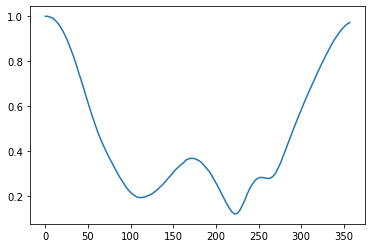

In [25]:
plt.plot(bbeam.df_angle,np.abs(bbeam.complex_H_beam[:,400]/bbeam.complex_H_beam[0,400]))